In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, auc
import pickle
import os

In [5]:
data= pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
print(f"Dataset Shape: {data.shape}")
print("\nFirst 5 rows:\n", data.head())
print("\nData Types:\n", data.dtypes)

original_data = data.copy()

Dataset Shape: (1470, 35)

First 5 rows:
    Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction

In [6]:
def prepare_data(df):
    """Initial data preparation before encoding and scaling"""
    df = df.copy()
    df = df.drop(columns=['EmployeeNumber', 'StandardHours', 'Over18', 'EmployeeCount'])

    if 'Attrition' in df.columns:
        df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
        y = df['Attrition']
        X = df.drop(columns=['Attrition'])
    else:
        y = None
        X = df

    return X, y

def fit_encoder(X):
    """Fit OneHotEncoder to categorical features"""
    categorical_cols = X.select_dtypes(include=['object']).columns
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    if len(categorical_cols) > 0:
        encoder.fit(X[categorical_cols])
    return encoder, categorical_cols

def apply_encoding(X, encoder, categorical_cols):
    """Apply fitted encoder to transform categorical features"""
    X = X.copy()
    if len(categorical_cols) > 0:
        encoded_cats = pd.DataFrame(encoder.transform(X[categorical_cols]))
        encoded_cats.columns = encoder.get_feature_names_out(categorical_cols)
        X = X.drop(columns=categorical_cols)
        X = pd.concat([X, encoded_cats], axis=1)
    return X

def fit_scaler(X):
    """Fit StandardScaler to numerical features"""
    scaler = StandardScaler()
    scaler.fit(X)
    return scaler

def apply_scaling(X, scaler):
    """Apply fitted scaler to transform features"""
    X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)
    return X_scaled

def preprocess_for_training(df):
    """Complete preprocessing pipeline for training data"""
    X, y = prepare_data(df)
    encoder, categorical_cols = fit_encoder(X)
    X = apply_encoding(X, encoder, categorical_cols)
    scaler = fit_scaler(X)
    X = apply_scaling(X, scaler)
    return X, y, encoder, categorical_cols, scaler

def preprocess_for_prediction(df, encoder, categorical_cols, scaler):
    """Complete preprocessing pipeline for prediction data"""
    X, y = prepare_data(df)
    X = apply_encoding(X, encoder, categorical_cols)
    X = apply_scaling(X, scaler)
    return X, y

In [7]:
#Process data with updated functions
X, y, encoder, categorical_cols, scaler = preprocess_for_training(data)

print("\nClass distribution:")
print(y.value_counts())
print(f"Attrition rate: {y.mean()*100:.2f}%")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training Set: {X_train.shape}, Testing Set: {X_test.shape}")


Class distribution:
Attrition
0    1233
1     237
Name: count, dtype: int64
Attrition rate: 16.12%
Training Set: (1176, 44), Testing Set: (294, 44)


In [8]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

print("\nModel Evaluation (Cross-Validation):")
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_results[name] = scores.mean()
    print(f"{name}: Mean Accuracy = {scores.mean():.4f}")

best_model_name = max(cv_results, key=cv_results.get)
print(f"\nBest model based on cross-validation: {best_model_name} (Accuracy: {cv_results[best_model_name]:.4f})")

best_model = models[best_model_name]
best_model.fit(X_train, y_train)


Model Evaluation (Cross-Validation):
Logistic Regression: Mean Accuracy = 0.8844
Random Forest: Mean Accuracy = 0.8631
XGBoost: Mean Accuracy = 0.8597
CatBoost: Mean Accuracy = 0.8733

Best model based on cross-validation: Logistic Regression (Accuracy: 0.8844)


LogisticRegression(max_iter=1000)


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92       247
           1       0.62      0.34      0.44        47

    accuracy                           0.86       294
   macro avg       0.75      0.65      0.68       294
weighted avg       0.84      0.86      0.84       294

ROC-AUC Score: 0.8079


<Figure size 800x600 with 0 Axes>

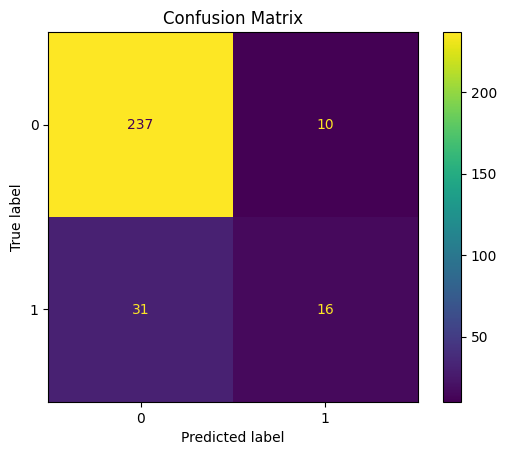

Precision-Recall AUC: 0.5681


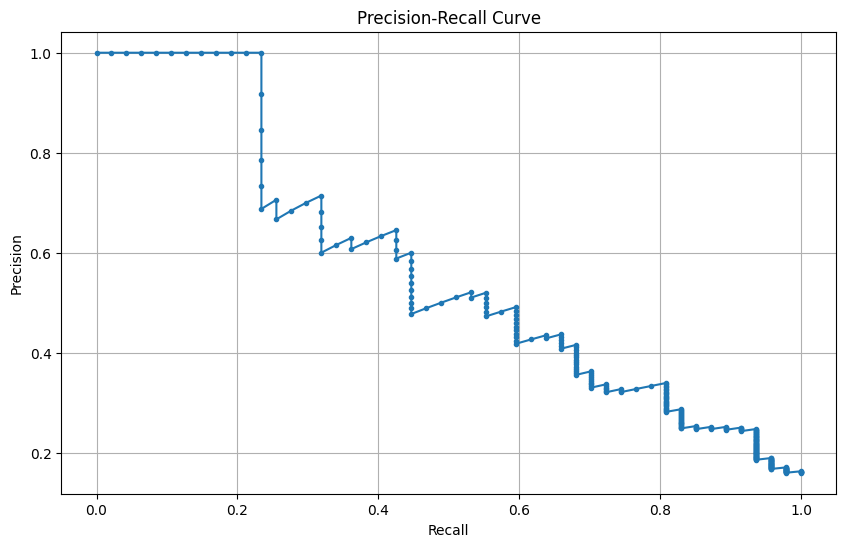

In [9]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title("Confusion Matrix")
plt.show()

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

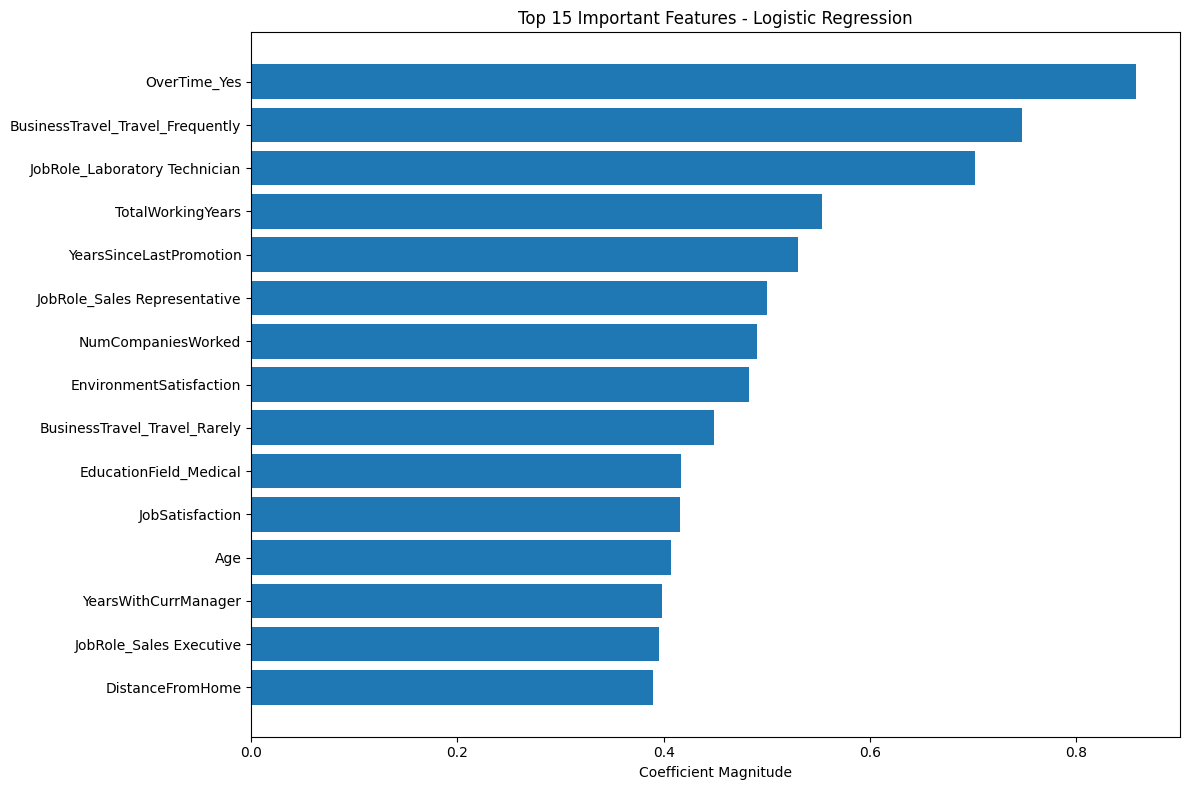


Business Insights:
Top factors driving employee attrition:
1. OverTime_Yes: 0.8578
2. BusinessTravel_Travel_Frequently: 0.7478
3. JobRole_Laboratory Technician: 0.7015
4. TotalWorkingYears: 0.5536
5. YearsSinceLastPromotion: 0.5300
6. JobRole_Sales Representative: 0.5006
7. NumCompaniesWorked: 0.4903
8. EnvironmentSatisfaction: 0.4831
9. BusinessTravel_Travel_Rarely: 0.4493
10. EducationField_Medical: 0.4164


In [10]:
plt.figure(figsize=(12, 8))
if hasattr(best_model, "feature_importances_"):
    # For tree-based models
    feature_importance = best_model.feature_importances_
    feature_names = X_train.columns

    # Sort and visualize top 15 important features
    indices = np.argsort(feature_importance)[-15:]
    plt.barh(range(len(indices)), feature_importance[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.title(f"Top 15 Important Features - {best_model_name}")
    plt.xlabel("Feature Importance")
elif hasattr(best_model, "coef_"): #logistic regression
    feature_importance = np.abs(best_model.coef_[0])
    feature_names = X_train.columns

    indices = np.argsort(feature_importance)[-15:]
    plt.barh(range(len(indices)), feature_importance[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.title(f"Top 15 Important Features - {best_model_name}")
    plt.xlabel("Coefficient Magnitude")
else:
    print("Feature importance not directly available for this model type")

plt.tight_layout()
plt.show()

print("\nBusiness Insights:")
if hasattr(best_model, "feature_importances_") or hasattr(best_model, "coef_"):
    if hasattr(best_model, "feature_importances_"):
        importances = best_model.feature_importances_
    else:
        importances = np.abs(best_model.coef_[0])

    feature_imp = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
    feature_imp = feature_imp.sort_values('Importance', ascending=False).head(10)

    print("Top factors driving employee attrition:")
    for i, (feature, importance) in enumerate(zip(feature_imp['Feature'], feature_imp['Importance']), 1):
        print(f"{i}. {feature}: {importance:.4f}")

In [11]:

if best_model_name == "Random Forest":
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
elif best_model_name == "XGBoost":
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1]
    }
elif best_model_name == "Logistic Regression":
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['liblinear', 'saga']
    }
elif best_model_name == "CatBoost":
    param_grid = {
        'iterations': [100, 200],
        'depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1]
    }

print(f"\nPerforming hyperparameter tuning for {best_model_name}...")
grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

final_model = grid_search.best_estimator_
final_model.fit(X_train, y_train)

y_pred_final = final_model.predict(X_test)
print("\nFinal Classification Report:\n", classification_report(y_test, y_pred_final))


Performing hyperparameter tuning for Logistic Regression...


C:\Users\KIIT\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\KIIT\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\KIIT\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\KIIT\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score: 0.8852

Final Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92       247
           1       0.62      0.34      0.44        47

    accuracy                           0.86       294
   macro avg       0.75      0.65      0.68       294
weighted avg       0.84      0.86      0.84       294



C:\Users\KIIT\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [12]:
model_filename = 'attrition_model.pkl'
encoder_filename = 'attrition_encoder.pkl'
categorical_cols_filename = 'categorical_cols.pkl'
scaler_filename = 'attrition_scaler.pkl'
column_filename = 'feature_columns.pkl'

with open(model_filename, 'wb') as f:
    pickle.dump(final_model, f)

with open(encoder_filename, 'wb') as f:
    pickle.dump(encoder, f)

with open(categorical_cols_filename, 'wb') as f:
    pickle.dump(categorical_cols, f)

with open(scaler_filename, 'wb') as f:
    pickle.dump(scaler, f)

with open(column_filename, 'wb') as f:
    pickle.dump(list(X.columns), f)

print(f"Model saved to {model_filename}")
print(f"Encoder saved to {encoder_filename}")
print(f"Categorical columns saved to {categorical_cols_filename}")
print(f"Scaler saved to {scaler_filename}")
print(f"Feature columns saved to {column_filename}")

Model saved to attrition_model.pkl
Encoder saved to attrition_encoder.pkl
Categorical columns saved to categorical_cols.pkl
Scaler saved to attrition_scaler.pkl
Feature columns saved to feature_columns.pkl


In [13]:
def load_model_components():
    """Load all saved model components"""
    with open('attrition_model.pkl', 'rb') as f:
        model = pickle.load(f)

    with open('attrition_encoder.pkl', 'rb') as f:
        encoder = pickle.load(f)

    with open('categorical_cols.pkl', 'rb') as f:
        categorical_cols = pickle.load(f)

    with open('attrition_scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)

    with open('feature_columns.pkl', 'rb') as f:
        columns = pickle.load(f)

    return model, encoder, categorical_cols, scaler, columns

def predict_employee_attrition(employee_data, original_data=None):
    """
    Predict attrition for a single employee using saved model components

    Parameters:
    employee_data: Dictionary with employee attributes
    original_data: Original dataset (for reference columns), optional

    Returns:
    prediction: 0 (stay) or 1 (leave)
    probability: Probability of attrition
    """
    model, encoder, categorical_cols, scaler, feature_columns = load_model_components()

    # DataFrame from employee data
    employee_df = pd.DataFrame([employee_data])

    # fill in missing columns
    if original_data is not None:
        for col in original_data.columns:
            if col not in employee_df.columns and col != 'Attrition':
                employee_df[col] = original_data[col].iloc[0]  # Using first value as default

    # preprocessing using loaded components
    X_employee, _ = preprocess_for_prediction(employee_df, encoder, categorical_cols, scaler)

    # columns match training data and are in the same order
    missing_cols = set(feature_columns) - set(X_employee.columns)
    for col in missing_cols:
        X_employee[col] = 0  # Add missing columns with zero values

    X_employee = X_employee[feature_columns]

    # Make prediction
    prediction = model.predict(X_employee)[0]
    probability = model.predict_proba(X_employee)[0][1]  # Probability of attrition

    return prediction, probability

In [14]:
# sample employee
test_employee = {
    'Age': 24,
    'BusinessTravel': 'Travel_Frequently',         # Frequent travel → more stress
    'DailyRate': 300,                              # Lower compensation
    'Department': 'Sales',                         # Possibly high-pressure environment
    'DistanceFromHome': 25,                        # Long commute
    'Education': 2,                                # Moderate education
    'EducationField': 'Marketing',
    'EnvironmentSatisfaction': 1,                  # Not satisfied with work environment
    'Gender': 'Male',
    'HourlyRate': 35,
    'JobInvolvement': 1,                           # Not very engaged
    'JobLevel': 1,                                 # Entry-level
    'JobRole': 'Sales Executive',
    'JobSatisfaction': 1,                          # Not happy in the role
    'MaritalStatus': 'Single',                     # May indicate fewer external obligations
    'MonthlyIncome': 2500,                         # Lower salary
    'MonthlyRate': 2000,
    'NumCompaniesWorked': 5,                       # Job hopper behavior
    'OverTime': 'Yes',                             # Working overtime often → burnout
    'PercentSalaryHike': 11,
    'PerformanceRating': 3,
    'RelationshipSatisfaction': 1,                 # Poor relations
    'StockOptionLevel': 0,                         # No incentives to stay
    'TotalWorkingYears': 3,                        # Not very experienced
    'TrainingTimesLastYear': 1,                    # Not much upskilling
    'WorkLifeBalance': 1,                          # Poor balance
    'YearsAtCompany': 1,                           # Recently joined
    'YearsInCurrentRole': 1,
    'YearsSinceLastPromotion': 0,                  # No advancement
    'YearsWithCurrManager': 0
}

try:
    prediction, probability = predict_employee_attrition(test_employee, original_data)

    print("\n--- Prediction Results ---")
    if prediction == 1:
        result = "ATTRITION RISK: This employee is predicted to leave"
    else:
        result = "RETENTION LIKELY: This employee is predicted to stay"

    print(result)
    print(f"Attrition probability: {probability:.2%}")
except FileNotFoundError:
    print("Model files not found. Please run the training and saving cells first.")


--- Prediction Results ---
ATTRITION RISK: This employee is predicted to leave
Attrition probability: 99.92%


In [15]:
def predict_with_custom_input():
    """Interactive function to predict attrition with custom input using saved model"""
    print("\n--- Custom Employee Attrition Prediction ---")

    # Load saved model components
    try:
        # No arguments needed for load_model_components now
        loaded_model, loaded_encoder, categorical_cols, loaded_scaler, feature_columns = load_model_components()
        print("Model loaded successfully!")
    except FileNotFoundError:
        print("Error: Model files not found. Please train and save the model first.")
        return None, None

    print("Enter employee information:")

    # You can modify this dictionary to take user input for each field
    custom_employee = {
    # 'Age': 24,
    # 'BusinessTravel': 'Travel_Frequently',         # Frequent travel → more stress
    # 'DailyRate': 300,                              # Lower compensation
    # 'Department': 'Sales',                         # Possibly high-pressure environment
    # 'DistanceFromHome': 25,                        # Long commute
    # 'Education': 2,                                # Moderate education
    # 'EducationField': 'Marketing',
    # 'EnvironmentSatisfaction': 1,                  # Not satisfied with work environment
    # 'Gender': 'Male',
    # 'HourlyRate': 35,
    # 'JobInvolvement': 1,                           # Not very engaged
    # 'JobLevel': 1,                                 # Entry-level
    # 'JobRole': 'Sales Executive',
    # 'JobSatisfaction': 1,                          # Not happy in the role
    # 'MaritalStatus': 'Single',                     # May indicate fewer external obligations
    # 'MonthlyIncome': 2500,                         # Lower salary
    # 'MonthlyRate': 2000,
    # 'NumCompaniesWorked': 5,                       # Job hopper behavior
    # 'OverTime': 'Yes',                             # Working overtime often → burnout
    # 'PercentSalaryHike': 11,
    # 'PerformanceRating': 3,
    # 'RelationshipSatisfaction': 1,                 # Poor relations
    # 'StockOptionLevel': 0,                         # No incentives to stay
    # 'TotalWorkingYears': 3,                        # Not very experienced
    # 'TrainingTimesLastYear': 1,                    # Not much upskilling
    # 'WorkLifeBalance': 1,                          # Poor balance
    # 'YearsAtCompany': 1,                           # Recently joined
    # 'YearsInCurrentRole': 1,
    # 'YearsSinceLastPromotion': 0,                  # No advancement
    # 'YearsWithCurrManager': 0
    'Age': 45,
    'BusinessTravel': 'Non-Travel',
    'DailyRate': 1100,
    'Department': 'Research & Development',
    'DistanceFromHome': 5,
    'Education': 4,
    'EducationField': 'Life Sciences',
    'EnvironmentSatisfaction': 4,
    'Gender': 'Female',
    'HourlyRate': 70,
    'JobInvolvement': 4,
    'JobLevel': 4,
    'JobRole': 'Healthcare Representative',
    'JobSatisfaction': 4,
    'MaritalStatus': 'Married',
    'MonthlyIncome': 15000,
    'MonthlyRate': 18000,
    'NumCompaniesWorked': 1,
    'OverTime': 'No',
    'PercentSalaryHike': 20,
    'PerformanceRating': 4,
    'RelationshipSatisfaction': 4,
    'StockOptionLevel': 2,
    'TotalWorkingYears': 20,
    'TrainingTimesLastYear': 4,
    'WorkLifeBalance': 4,
    'YearsAtCompany': 12,
    'YearsInCurrentRole': 8,
    'YearsSinceLastPromotion': 3,
    'YearsWithCurrManager': 7
    }

    print("\nPredicting attrition for employee with the following attributes:")
    for key, value in custom_employee.items():
        print(f"{key}: {value}")

    # Use the simpler predict_employee_attrition function
    prediction, probability = predict_employee_attrition(custom_employee, original_data)

    print("\n--- Prediction Results ---")
    if prediction == 1:
        result = "ATTRITION RISK: This employee is predicted to leave"
    else:
        result = "RETENTION LIKELY: This employee is predicted to stay"

    print(result)
    print(f"Attrition probability: {probability:.2%}")

    # If high risk, identify key factors
    if probability > 0.3:  # Using 0.3 as a threshold here
        print("\nKey risk factors to address:")
        # Use loaded model for feature importance
        if hasattr(loaded_model, "feature_importances_"):
            importances = loaded_model.feature_importances_
        elif hasattr(loaded_model, "coef_"):
            importances = np.abs(loaded_model.coef_[0])
        else:
            print("Unable to determine key factors with this model type")
            return prediction, probability

        feature_imp = pd.DataFrame({'Feature': feature_columns, 'Importance': importances})
        feature_imp = feature_imp.sort_values('Importance', ascending=False).head(5)

        for i, (feature, _) in enumerate(zip(feature_imp['Feature'], feature_imp['Importance']), 1):
            print(f"{i}. {feature}")

    return prediction, probability

In [16]:
# Call the function to predict with custom employee data
try:
    pred, prob = predict_with_custom_input()
except Exception as e:
    print(f"Error during prediction: {e}")


--- Custom Employee Attrition Prediction ---
Model loaded successfully!
Enter employee information:

Predicting attrition for employee with the following attributes:
Age: 45
BusinessTravel: Non-Travel
DailyRate: 1100
Department: Research & Development
DistanceFromHome: 5
Education: 4
EducationField: Life Sciences
EnvironmentSatisfaction: 4
Gender: Female
HourlyRate: 70
JobInvolvement: 4
JobLevel: 4
JobRole: Healthcare Representative
JobSatisfaction: 4
MaritalStatus: Married
MonthlyIncome: 15000
MonthlyRate: 18000
NumCompaniesWorked: 1
OverTime: No
PercentSalaryHike: 20
PerformanceRating: 4
RelationshipSatisfaction: 4
StockOptionLevel: 2
TotalWorkingYears: 20
TrainingTimesLastYear: 4
WorkLifeBalance: 4
YearsAtCompany: 12
YearsInCurrentRole: 8
YearsSinceLastPromotion: 3
YearsWithCurrManager: 7

--- Prediction Results ---
RETENTION LIKELY: This employee is predicted to stay
Attrition probability: 0.01%
